In [1]:
import household_contact_tracing.BranchingProcessSimulation as hct
from household_contact_tracing.simulation_controller import SimulationController

# Notebook purpose
To provide minimal working examples of various model functionalities.

# Household level contact tracing
The first implementation of the contact tracing model uses household level contact tracing. By this, we mean that if a case is detected in a household, all members of the household will trace their contacts. When an individual is traced, their entire household goes into isolation. This is slightly different to the "uk_model" implementation, which uses individual level tracing that I will document later.

# 1.1 - Simulate an epidemic
The most basic functionality of the model is to simulate a individual-household branching process model of SARS-CoV-2. We will turn off all the self isolation and contact tracing dynamics to begin with. Depsite there being no contact tracing, due to the current implementation we still have to specify contact tracing parameters...

We include asymptomatic individuals.

* No symptom reporting
* No self-isolation
* 

In [2]:
params = {'outside_household_infectivity_scaling': 0.7,
            'contact_tracing_success_prob': 0.0, # doesn't matter, no tracing
            'overdispersion': 0.32,
            'asymptomatic_prob': 0.2,
            'asymptomatic_relative_infectivity': 0.35,
            'infection_reporting_prob': 0,
            'contact_trace': False,
            'test_delay': 2,
            'contact_trace_delay': 1,
            'incubation_period_delay': 5,
            'symptom_reporting_delay': 1,
            'household_pairwise_survival_prob': 0.2,
            'do_2_step': False,                      # doesn't matter, no tracing
            'reduce_contacts_by': 0.3,
            'prob_has_trace_app': 0,                 # doesn't matter, no tracing
            'hh_propensity_to_use_trace_app': 1,     # doesn't matter, no tracing
            'test_before_propagate_tracing': True,   # doesn't matter, no tracing
            'starting_infections': 1, 
            'node_will_uptake_isolation_prob': 1,    # doesn't matter, no tracing
            'self_isolation_duration': 0,            # doesn't matter, no tracing
            'quarantine_duration': 0,                # doesn't matter, no tracing
            'transmission_probability_multiplier': 1, # this isn't really useable (I would argue for removing it)
            'propensity_imperfect_quarantine': 0,    # doesn't matter no tracing
            'global_contact_reduction_imperfect_quarantine': 0, # doesn't matter, no tracing

         }

In [3]:
model_just_an_epidemic = hct.household_sim_contact_tracing(params)

Already re-set and ready to run!


Changing to running state
shell view observed state change. New state: RunningState
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
Timed out st

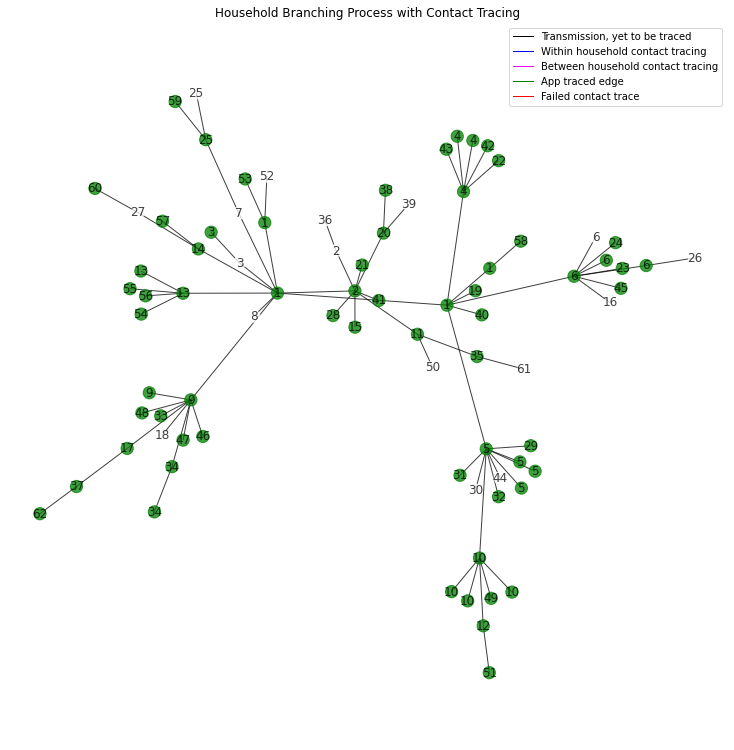

In [4]:
controller = SimulationController(model_just_an_epidemic)
controller.run_simulation(10)

# 1.2 - Simulate an epidemic, with household isolation initiated upon symptom onset
In this simulation, we will set the infection_reporting_probability to a non-zero value. This means that some individuals will develop symptoms, and report them, which initiates isolation of the entire household. When a nodes household is isolated all the nodes inside are isolated, and if the nodes are adhering to isolation they will not make outside household contacts, which results in a small decrease of the speed of the epidemic spreading. We have assumed perfect adherence in this simulation.

In [5]:
params['infection_reporting_prob'] = 0.5  
    # 50% of symptomatic individuals will report their symptoms, and self-isolate

In [6]:
model_self_reports_isolate = hct.household_sim_contact_tracing(params)

Already re-set and ready to run!


Changing to running state
shell view observed state change. New state: RunningState
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
Timed out state
shell view observed state change. New state: TimedOutState
graph view observed that simulation has stopped running


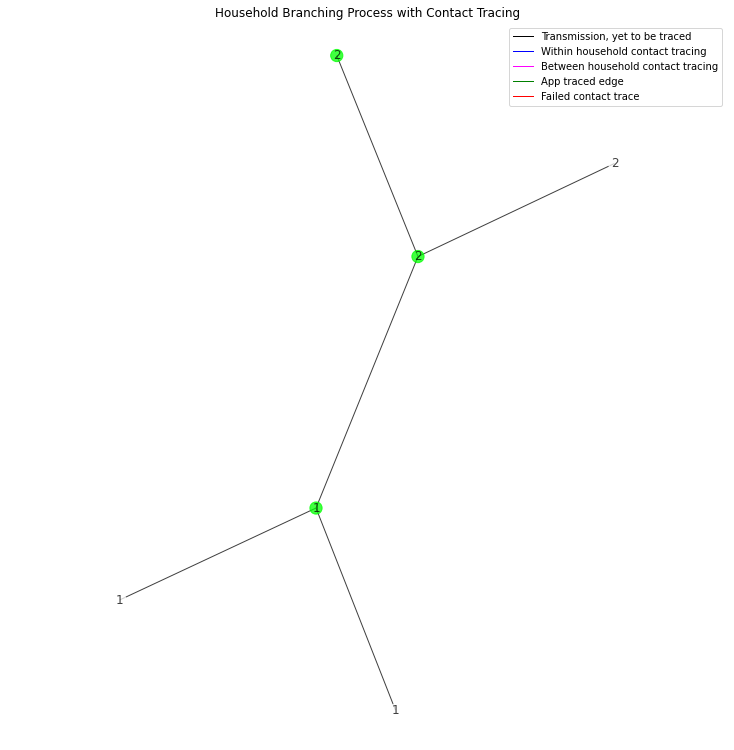

In [7]:
controller = SimulationController(model_self_reports_isolate)
controller.run_simulation(10)

In [8]:
[node for node in model_self_reports_isolate.network.all_nodes() if node.isolated]

[]

# 1.3 Simulate an epidemic, with household level contact tracing and tracing upon symptom onset
We now enable the contact tracing aspects of the model, using household level contact tracing perfromed upon symptom onset.
* Household level contact tracing means that when an infection is discovered in a household, contact tracing attempts are made to all connected Household
* When a household is reached, only the traced node isolates
* When a node in a traced household develops symptoms, the household is isolated and contact tracing is again propagated
* Being performed upon symptom onset means that testing is not performed, and symptoms alone are enough evidence to propagate contact tracing

This is a very non-standard model of contact tracing.

In [9]:
params['contact_tracing_success_prob'] = 0.7    # setting to a non-zero values enables contact tracing            
params['contact_trace'] = True                  # I don't think this parameter is doing anything at the moment         
params['self_isolation_duration'] = 10            
params['quarantine_duration'] = 10

In [10]:
model_household_level_tracing_upon_symptom_onset = hct.household_sim_contact_tracing(params)

Already re-set and ready to run!


Changing to running state
shell view observed state change. New state: RunningState
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
shell view observed graph change
shell view observed that Model has been incremented by one step
Timed out state
shell view observed state change. New state: TimedOutState
gra

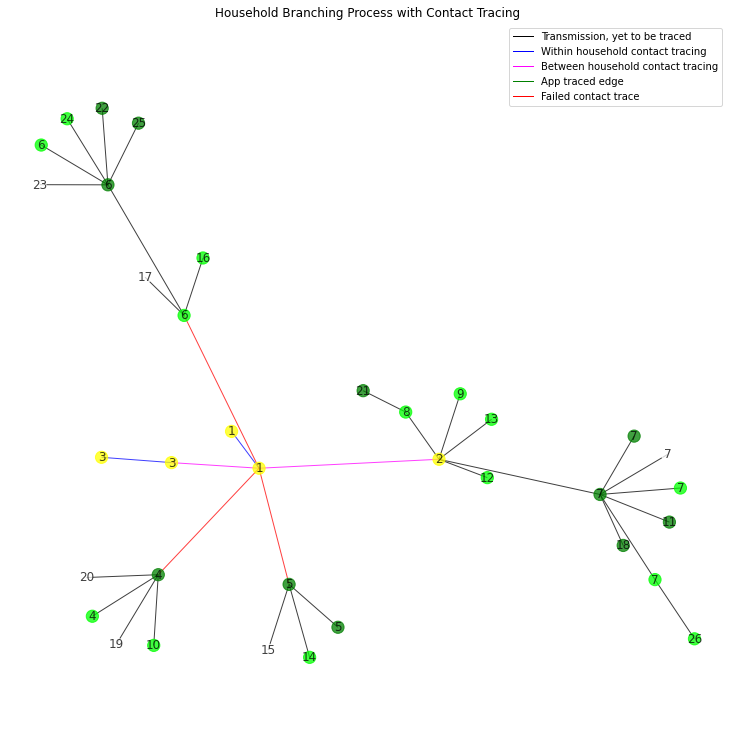

In [11]:
controller = SimulationController(model_household_level_tracing_upon_symptom_onset)
controller.run_simulation(10)

# 1.4 Simulate an epidemic, with household level contact tracing and testing delays
The same contact tracing strategy as before, but now we require test results. We assume that the test is always perfectly accurate, but has a delay associated. Contact tracing is only propagated when the test result has returned.

In [12]:
params['test_before_propagate_tracing'] = True   # We now require a test before propagating tracing'

In [13]:
model_household_level_tracing_after_test_result = hct.household_sim_contact_tracing(params)

Already re-set and ready to run!


Changing to running state
shell view observed state change. New state: RunningState
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
shell view observed that Model has been incremented by one step
Timed out state
shell view observed state change. New state: TimedOutState
graph view observed that simulation has stopped running


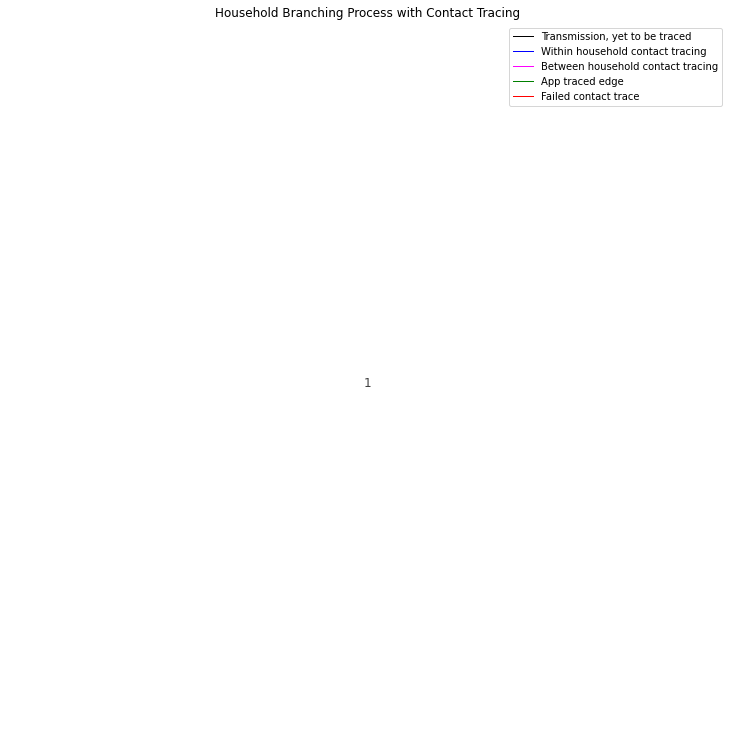

In [14]:
controller = SimulationController(model_household_level_tracing_after_test_result)
controller.run_simulation(10)

You wont be able to see much of a difference visually on this one. This nodes however have a non-zero testing delay value stored.

In [ ]:
model_household_level_tracing_after_test_result.network.node(1).testing_delay

# 1.5 Simulate an epidemic, with household level contact tracing, and digital contact tracing
We assign a proportion of the population to have digital contact tracing applications installed. If there is a contact tracing attempt between two nodes who both have the app installed, then we assume that the contact tracing attempt succeeds with 100% probability, and there is no contact tracing delay applied (so it is instantaneous and guaranteed to work, which is optimistic).

The uptake of the tracing can be clustered by households (ie. some household will never uptake the contact tracing app), however we never really make much use of this in practice.

In [ ]:
params['prob_has_trace_app'] = 0.6  # 60% of the population now have the contact tracing application installed
params['test_before_propagate_tracing'] = False   # Trace upon symtpom onset  

In [ ]:
model_household_level_tracing_with_digital_tracing = hct.household_sim_contact_tracing(params)

In [ ]:
controller = SimulationController(model_household_level_tracing_with_digital_tracing)
controller.reset()
controller.run_simulation(10)

The presence of green edges means that the edge was traced digitally.

# 1.6 Simulate an epidemic, with household level contact tracing, and non-uptake of isolation
We now allow for some non-adherence. This is the simplest possible model, where some nodes will simply not uptake isolation (they will list their contacts however). This is different to imperfect quarantine.

In [ ]:
params['prob_has_trace_app'] = 0  # 60% of the population now have the contact tracing application installed         
params['node_will_uptake_isolation_prob'] = 0.5 # Now, only 50% of nodes will uptake isolation, resulting in less effective contact tracing

In [ ]:
model_household_level_tracing_with_non_uptake_of_isolation = hct.household_sim_contact_tracing(params)

In [ ]:
controller = SimulationController(model_household_level_tracing_with_non_uptake_of_isolation)
controller.run_simulation(10)

You might see contact traced nodes who are not isolated, or household where all nodes should be isolated, but only some are.

# 1.7 Simulate an epidemic, with household level contact tracing, and imperfect isolation

We now assume that some nodes do isolate or quarantine, but do it badly. An untraced individual will reduce their outside household contacts by 30% by performing social distancing, an individual doing perfect isolation/quarantine will reduce their outside household contacts by 100%, an individual who is imperfectly isolating/quarantining will reduce their outside household contacts by say, 75%.

In [ ]:
params['node_will_uptake_isolation_prob'] = 1    # all nodes will at least uptake isolation
params['propensity_imperfect_quarantine'] = 0.5   # now, 50% of nodes will isolate, but will do it badly 
params['global_contact_reduction_imperfect_quarantine'] = 0.75 # a node doing imperfect isolation will reduce their outside household contacts by 75%

In [ ]:
model_household_level_tracing_with_imperfect_isolation = hct.household_sim_contact_tracing(params)

In [ ]:
controller = SimulationController(model_household_level_tracing_with_imperfect_isolation)
controller.run_simulation(10)

There are no visual indicators of imperfect isolation

In [ ]:
[
    node 
    for node 
    in model_household_level_tracing_with_imperfect_isolation.network.all_nodes()
    if node.propensity_imperfect_isolation
]

In [ ]:
[
    model_household_level_tracing_with_imperfect_isolation.get_contact_rate_reduction(node)
    for node 
    in model_household_level_tracing_with_imperfect_isolation.network.all_nodes()
    if node.propensity_imperfect_isolation
]

Some of the values are 0.3 - these are the nodes who do not currently have to isolate.

# 1.8 Epidemic, with household level contact tracing and two-step household contact tracing

Two step contact tracing is a contact tracing strategy where:
* An index case is discovered
* Their contacts are traced
* The contact of the traced contacts are then traced

It is an attempt to speed up contact tracing. Ordinarily, you would trace someone, and wait for them to get symptoms before tracing again. Now you just trace everyone who is distance=2 from a known case. Because this is the household level contact tracing, the two-step tracing occurs at the level of households. So, we aim to isolate all households that are distance two from a known household with an infection. This is a very non-standard implementation of two-step contact tracing. If two individuals live in the same housheold, the distance between them is 0. If two individuals live in seperate households, but there was a contact between them, then the distance between them is 1. I should probably make a diagram of this at some point.

In [ ]:
params['do_2_step']: True                       # we are doing two step tracing
params['propensity_imperfect_quarantine']: 0    # Assume perfect quarantine
params['global_contact_reduction_imperfect_quarantine']: 0 # a node doing imperfect isolation will reduce their outside household contacts by 0

In [ ]:
model_household_level_tracing_with_two_step_contact_tracing = hct.household_sim_contact_tracing(params)

In [ ]:
controller = SimulationController(model_household_level_tracing_with_two_step_contact_tracing)
controller.run_simulation(10)

In [ ]:
controller.run_simulation(1)